#Project 1 - Sales Forecasting (Time Series Analysis)

Goal: Predict future sales trends without deep learning.

  What to do:
Use ARIMA, SARIMA, or Prophet for time-series forecasting.
Decompose the data into trends, seasonality, and residuals.
Forecast monthly or weekly sales to better understand demand patterns.
Why it's useful: Helps with inventory planning and ensuring you have enough stock for high-demand periods.

##Data Dictionary

##Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose, STL

In [2]:
import warnings
warnings.filterwarnings('ignore')

##Overview of Data

### Uploading data

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Ventas totales a lo largo del tiempo - CHANNEL NAME - 2020-01-01 - 2024-12-31.csv to Ventas totales a lo largo del tiempo - CHANNEL NAME - 2020-01-01 - 2024-12-31.csv


In [4]:
data = pd.read_csv('Ventas totales a lo largo del tiempo - CHANNEL NAME - 2020-01-01 - 2024-12-31.csv')

In [5]:
data.head()

,Mes,Pedidos,Ventas brutas,Descuentos,Devoluciones,Ventas netas,Cargos de envío,Aranceles,Cargos adicionales,Impuestos,Ventas totales,Nombre de la sucursal de POS,Canal de ventas
0,2020-01-01,2,700.0,0.0,0.0,700.0,0,0,0,0.0,700.0,Distribuidores,Point of Sale
1,2020-01-01,4,2050.0,0.0,0.0,2050.0,360,0,0,0.0,2410.0,NaN,Online Store
2,2020-02-01,5,6350.0,-119.0,-120.0,6111.0,340,0,0,0.0,6451.0,NaN,Online Store
3,2020-03-01,1,6710.0,-2348.5,0.0,4361.5,0,0,0,0.0,4361.5,Distribuidores,Draft Orders
4,2020-03-01,6,6600.0,-526.5,-1990.0,4083.5,170,0,0,136.8,4390.3,NaN,Online Store


### Data pre-processing

In [6]:
df = data.copy()

In [7]:
# I want to eliminate the columns that won't be usefull for this analysis
df = df.drop(['Ventas brutas', 'Descuentos','Devoluciones','Cargos de envío', 'Aranceles','Cargos adicionales','Impuestos','Ventas totales'],axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Mes                           239 non-null    object 
 1   Pedidos                       239 non-null    int64  
 2   Ventas netas                  239 non-null    float64
 3   Nombre de la sucursal de POS  183 non-null    object 
 4   Canal de ventas               239 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 9.5+ KB


In [9]:
df.head()

,Mes,Pedidos,Ventas netas,Nombre de la sucursal de POS,Canal de ventas
0,2020-01-01,2,700.0,Distribuidores,Point of Sale
1,2020-01-01,4,2050.0,NaN,Online Store
2,2020-02-01,5,6111.0,NaN,Online Store
3,2020-03-01,1,4361.5,Distribuidores,Draft Orders
4,2020-03-01,6,4083.5,NaN,Online Store


In [10]:
df['Canal de ventas'].value_counts()

,count
Canal de ventas,
Point of Sale,179
Online Store,55
Draft Orders,5


In [11]:
# I see some Draft Orders along the sales channel. These won't be usefull since they are not actual sales.
# I will create a new dataframe without them.
df_sales = df[df['Canal de ventas'] != 'Draft Orders']
df_sales

,Mes,Pedidos,Ventas netas,Nombre de la sucursal de POS,Canal de ventas
0,2020-01-01,2,700.00,Distribuidores,Point of Sale
1,2020-01-01,4,2050.00,NaN,Online Store
2,2020-02-01,5,6111.00,NaN,Online Store
4,2020-03-01,6,4083.50,NaN,Online Store
5,2020-04-01,6,3826.50,Distribuidores,Point of Sale
...,...,...,...,...,...
234,2024-11-01,68,47829.00,Reliz,Point of Sale
235,2024-12-01,193,207390.70,Liuum (Plaza B2),Point of Sale
236,2024-12-01,1,2790.00,NaN,Online Store
237,2024-12-01,103,89783.00,Reliz,Point of Sale


In [12]:
df_sales['Canal de ventas'].value_counts()

,count
Canal de ventas,
Point of Sale,179
Online Store,55


In [13]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 234 entries, 0 to 238
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Mes                           234 non-null    object 
 1   Pedidos                       234 non-null    int64  
 2   Ventas netas                  234 non-null    float64
 3   Nombre de la sucursal de POS  179 non-null    object 
 4   Canal de ventas               234 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 19.1+ KB


#### **Treating missing values**

- Now lets treat the missing values for the column 'Nombre de la sucursal de POS'

In [14]:
df_sales['Nombre de la sucursal de POS'].isnull().value_counts()

,count
Nombre de la sucursal de POS,
False,179
True,55


In [15]:
# Having a look at the rows with missing values in the Column Nombre de la sucursal de POS
missing_values = df_sales[df_sales['Nombre de la sucursal de POS'].isna()]
missing_values

,Mes,Pedidos,Ventas netas,Nombre de la sucursal de POS,Canal de ventas
1,2020-01-01,4,2050.0,NaN,Online Store
2,2020-02-01,5,6111.0,NaN,Online Store
4,2020-03-01,6,4083.5,NaN,Online Store
6,2020-04-01,8,5335.0,NaN,Online Store
8,2020-05-01,22,13064.5,NaN,Online Store
11,2020-06-01,27,20817.0,NaN,Online Store
13,2020-07-01,14,17987.5,NaN,Online Store
14,2020-08-01,18,19198.0,NaN,Online Store
17,2020-09-01,7,6254.0,NaN,Online Store
19,2020-10-01,13,10574.0,NaN,Online Store


- It looks like the missing data is from sales made from the online channel. I will input the Online channel information in the missing values.


In [16]:
# Replace NaN values in 'Nombre de la sucursal de POS' column with corresponding values from 'Canal de ventas' column where 'Canal de ventas' is 'Online Store'
df_sales['Nombre de la sucursal de POS'] = df_sales.apply(lambda row: row['Nombre de la sucursal de POS'] if pd.notna(row['Nombre de la sucursal de POS']) else row['Canal de ventas'] if row['Canal de ventas'] == 'Online Store' else row['Nombre de la sucursal de POS'], axis=1)

In [17]:
df_sales['Nombre de la sucursal de POS'].isnull().sum()

0

In [18]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 234 entries, 0 to 238
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Mes                           234 non-null    object 
 1   Pedidos                       234 non-null    int64  
 2   Ventas netas                  234 non-null    float64
 3   Nombre de la sucursal de POS  234 non-null    object 
 4   Canal de ventas               234 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 19.1+ KB


#### **Setting time data to time type data and setting it as index**

1. Convert the date column to datetime using pd.to_datetime().
2. Set the column as the index using set_index().
- Time indexing is essential to organize, analyze, and model time-based data effectively.

In [19]:
# Convert 'Mes' column from object type to datetime
df_sales['Mes'] = pd.to_datetime(df['Mes'])

In [20]:
df_sales.dtypes

,0
Mes,datetime64[ns]
Pedidos,int64
Ventas netas,float64
Nombre de la sucursal de POS,object
Canal de ventas,object


In [21]:
# create a new dataframe called sales where the time column is on the index
sales = df_sales.set_index('Mes')
sales

,Pedidos,Ventas netas,Nombre de la sucursal de POS,Canal de ventas
Mes,,,,
2020-01-01,2,700.00,Distribuidores,Point of Sale
2020-01-01,4,2050.00,Online Store,Online Store
2020-02-01,5,6111.00,Online Store,Online Store
2020-03-01,6,4083.50,Online Store,Online Store
2020-04-01,6,3826.50,Distribuidores,Point of Sale
...,...,...,...,...
2024-11-01,68,47829.00,Reliz,Point of Sale
2024-12-01,193,207390.70,Liuum (Plaza B2),Point of Sale
2024-12-01,1,2790.00,Online Store,Online Store


In [22]:
sales = sales.rename_axis('Time_Stamp')
sales

,Pedidos,Ventas netas,Nombre de la sucursal de POS,Canal de ventas
Time_Stamp,,,,
2020-01-01,2,700.00,Distribuidores,Point of Sale
2020-01-01,4,2050.00,Online Store,Online Store
2020-02-01,5,6111.00,Online Store,Online Store
2020-03-01,6,4083.50,Online Store,Online Store
2020-04-01,6,3826.50,Distribuidores,Point of Sale
...,...,...,...,...
2024-11-01,68,47829.00,Reliz,Point of Sale
2024-12-01,193,207390.70,Liuum (Plaza B2),Point of Sale
2024-12-01,1,2790.00,Online Store,Online Store


In [23]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 234 entries, 2020-01-01 to 2024-12-01
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Pedidos                       234 non-null    int64  
 1   Ventas netas                  234 non-null    float64
 2   Nombre de la sucursal de POS  234 non-null    object 
 3   Canal de ventas               234 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 9.1+ KB


- Now the data set is ready to get some usefull insights.

#### Data for Store 'b2'

In [24]:
# isolating data from store called 'b2'
b2_sales = sales[sales['Nombre de la sucursal de POS']=='Liuum (Plaza B2)']
b2_sales.tail()

,Pedidos,Ventas netas,Nombre de la sucursal de POS,Canal de ventas
Time_Stamp,,,,
2024-08-01,89,61817.25,Liuum (Plaza B2),Point of Sale
2024-09-01,81,51317.80,Liuum (Plaza B2),Point of Sale
2024-10-01,80,50853.50,Liuum (Plaza B2),Point of Sale
2024-11-01,59,49596.00,Liuum (Plaza B2),Point of Sale
2024-12-01,193,207390.70,Liuum (Plaza B2),Point of Sale


In [25]:
b2_sales.drop(['Nombre de la sucursal de POS','Canal de ventas'], axis=1, inplace=True)
b2_sales.tail()

,Pedidos,Ventas netas
Time_Stamp,,
2024-08-01,89,61817.25
2024-09-01,81,51317.80
2024-10-01,80,50853.50
2024-11-01,59,49596.00
2024-12-01,193,207390.70


In [26]:
b2_pedidos = b2_sales.drop('Ventas netas', axis=1)
b2_pedidos.head()

,Pedidos
Time_Stamp,
2020-10-01,120
2020-11-01,99
2020-12-01,380
2021-01-01,133
2021-02-01,164


In [27]:
b2_ventasnetas = b2_sales.drop('Pedidos', axis=1)
b2_ventasnetas.head()

,Ventas netas
Time_Stamp,
2020-10-01,125853.5
2020-11-01,100015.5
2020-12-01,382721.0
2021-01-01,88804.5
2021-02-01,126349.6


In [28]:
b2_ventasnetas.shape

(51, 1)

##Exploratory Data Analysis

### Last pre-processing before EDA

In [29]:
print(sales.head())
print(df_sales.head())

            Pedidos  Ventas netas Nombre de la sucursal de POS Canal de ventas
Time_Stamp                                                                    
2020-01-01        2         700.0               Distribuidores   Point of Sale
2020-01-01        4        2050.0                 Online Store    Online Store
2020-02-01        5        6111.0                 Online Store    Online Store
2020-03-01        6        4083.5                 Online Store    Online Store
2020-04-01        6        3826.5               Distribuidores   Point of Sale
         Mes  Pedidos  Ventas netas Nombre de la sucursal de POS  \
0 2020-01-01        2         700.0               Distribuidores   
1 2020-01-01        4        2050.0                 Online Store   
2 2020-02-01        5        6111.0                 Online Store   
4 2020-03-01        6        4083.5                 Online Store   
5 2020-04-01        6        3826.5               Distribuidores   

  Canal de ventas  
0   Point of Sale 

In [30]:
df_sales.rename(columns={'Mes':'Time_Stamp'}, inplace=True)
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 234 entries, 0 to 238
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Time_Stamp                    234 non-null    datetime64[ns]
 1   Pedidos                       234 non-null    int64         
 2   Ventas netas                  234 non-null    float64       
 3   Nombre de la sucursal de POS  234 non-null    object        
 4   Canal de ventas               234 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 19.1+ KB


### EDA SALES

In [31]:
df_sales.head()

,Time_Stamp,Pedidos,Ventas netas,Nombre de la sucursal de POS,Canal de ventas
0,2020-01-01,2,700.0,Distribuidores,Point of Sale
1,2020-01-01,4,2050.0,Online Store,Online Store
2,2020-02-01,5,6111.0,Online Store,Online Store
4,2020-03-01,6,4083.5,Online Store,Online Store
5,2020-04-01,6,3826.5,Distribuidores,Point of Sale


##TIME SERIES ANALYSIS

### B2 Store

- Dataframe b2_ventasnetas will be used for analysis

In [32]:
print(b2_ventasnetas.head())
print(b2_ventasnetas.tail())

            Ventas netas
Time_Stamp              
2020-10-01      125853.5
2020-11-01      100015.5
2020-12-01      382721.0
2021-01-01       88804.5
2021-02-01      126349.6
            Ventas netas
Time_Stamp              
2024-08-01      61817.25
2024-09-01      51317.80
2024-10-01      50853.50
2024-11-01      49596.00
2024-12-01     207390.70


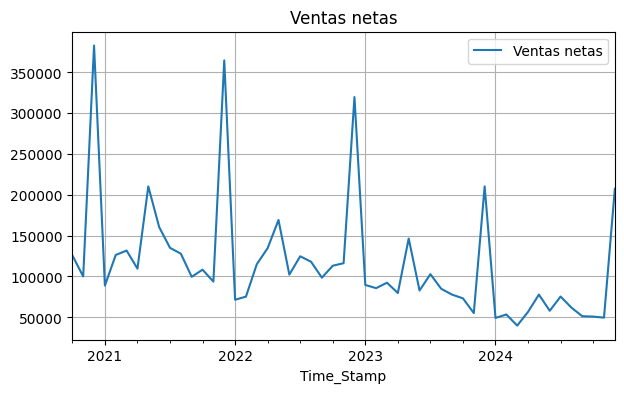

In [33]:
# Plotting the graph
b2_ventasnetas.plot(figsize=(7,4))
plt.grid()
plt.title('Ventas netas')
plt.show()

In [34]:
# Basic measures of descriptive statistics of the time series
round(b2_ventasnetas.describe(),2)

,Ventas netas
count,51.00
mean,116376.46
std,72986.15
min,39854.40
25%,75362.25
50%,99584.70
75%,127126.55
max,382721.00


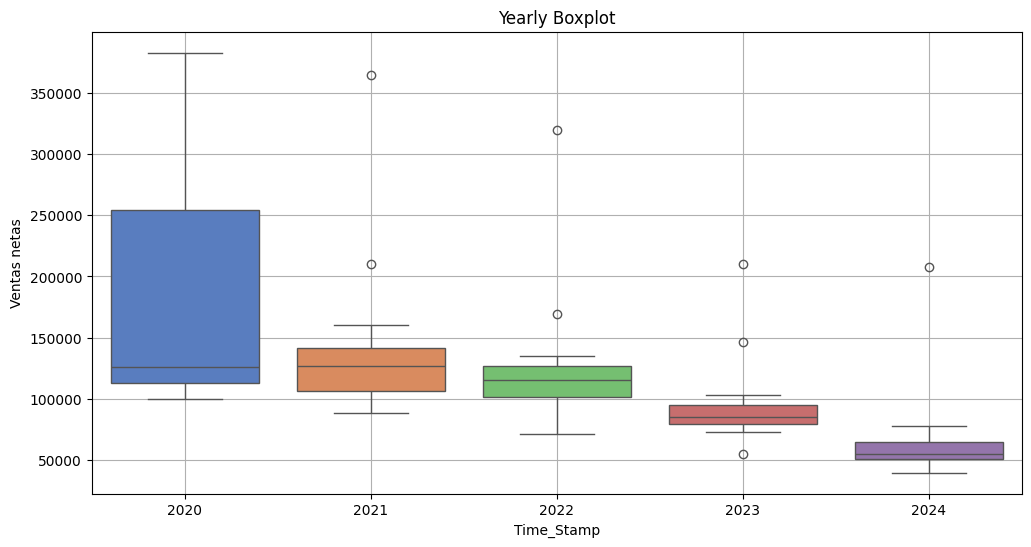

In [35]:
# yearly boxplot
_, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=b2_ventasnetas, x=b2_ventasnetas.index.year, y='Ventas netas', ax=ax, palette='muted')
plt.grid()
plt.title('Yearly Boxplot')
plt.show()

In [36]:
b2_ventasnetas['Month']=b2_ventasnetas.index.month_name()
b2_ventasnetas.head()

,Ventas netas,Month
Time_Stamp,,
2020-10-01,125853.5,October
2020-11-01,100015.5,November
2020-12-01,382721.0,December
2021-01-01,88804.5,January
2021-02-01,126349.6,February


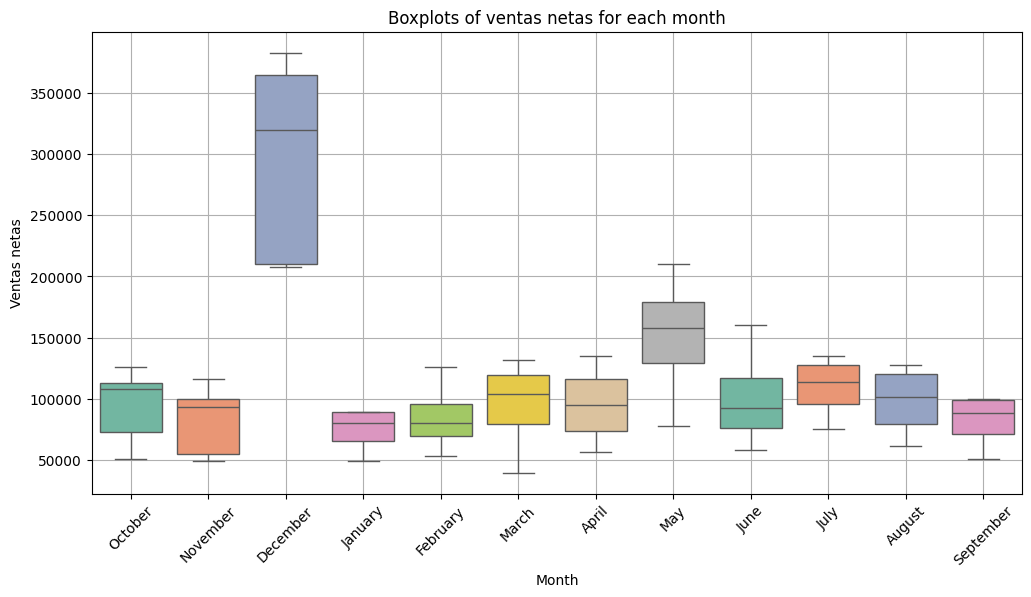

In [37]:
# Monthly boxplot
_, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=b2_ventasnetas, x='Month', y='Ventas netas', palette='Set2')
plt.xticks(rotation=45)
plt.grid()
plt.title('Boxplots of ventas netas for each month')
plt.show()

We see that there is a maximum sales in the month of December.

Plotting a graph of monthly sales across years

In [38]:
monthly_sales_across_years = pd.pivot_table(b2_ventasnetas, values='Ventas netas', columns=b2_ventasnetas.index.month_name(), index=b2_ventasnetas.index.year)
monthly_sales_across_years

Time_Stamp,April,August,December,February,January,July,June,March,May,November,October,September
Time_Stamp,,,,,,,,,,,,
2020,NaN,NaN,382721.00,NaN,NaN,NaN,NaN,NaN,NaN,100015.50,125853.50,NaN
2021,109582.07,127903.50,364594.50,126349.6,88804.50,135043.8,160519.20,131701.5,210310.20,93695.40,108289.00,99584.7
2022,134684.17,118020.30,319692.70,75312.5,71499.50,124708.5,102239.10,114973.6,169167.35,116247.25,113161.35,98530.0
2023,79713.35,84844.50,210299.05,85692.5,89569.05,102809.5,82816.75,92353.0,146399.75,55153.92,73205.00,77765.0
2024,56699.00,61817.25,207390.70,53455.2,49203.95,75412.0,58012.85,39854.4,77761.40,49596.00,50853.50,51317.8


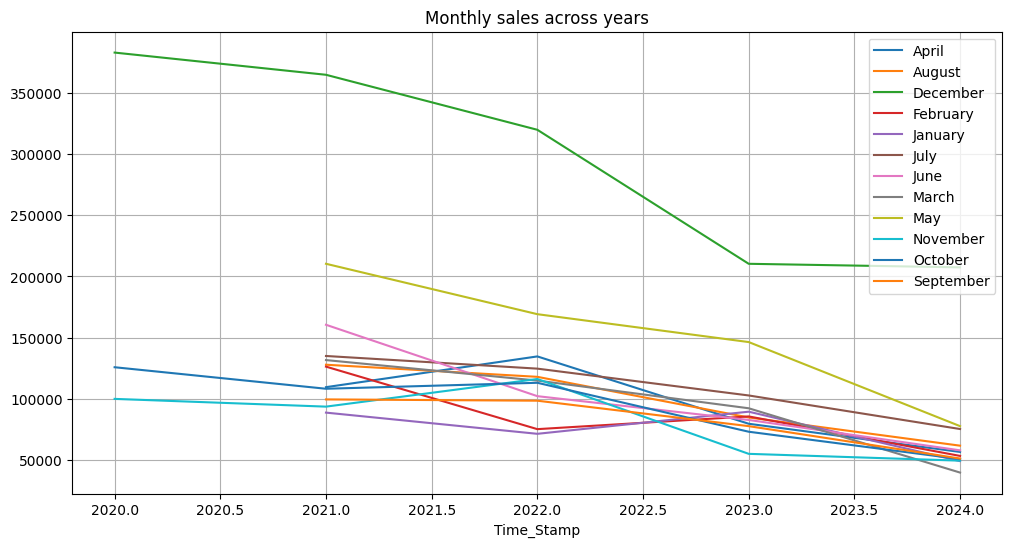

In [39]:
monthly_sales_across_years.plot(figsize=(12,6))
plt.grid()
plt.title('Monthly sales across years')
plt.legend(loc='best')
plt.show()

From the graph also, we can conclude that December has the highest sales across years.

In [40]:
b2_ventasnetas.drop('Month', axis=1, inplace=True)

In [41]:
b2_ventasnetas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51 entries, 2020-10-01 to 2024-12-01
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ventas netas  51 non-null     float64
dtypes: float64(1)
memory usage: 816.0 bytes


#### Moving average Decomosition



In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose

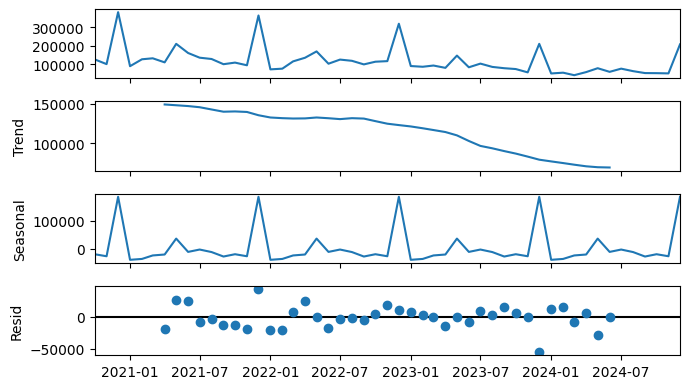

In [43]:
from pylab import rcParams
rcParams['figure.figsize']= 7,4

decomposition = seasonal_decompose(b2_ventasnetas, model='additive')
decomposition.plot();

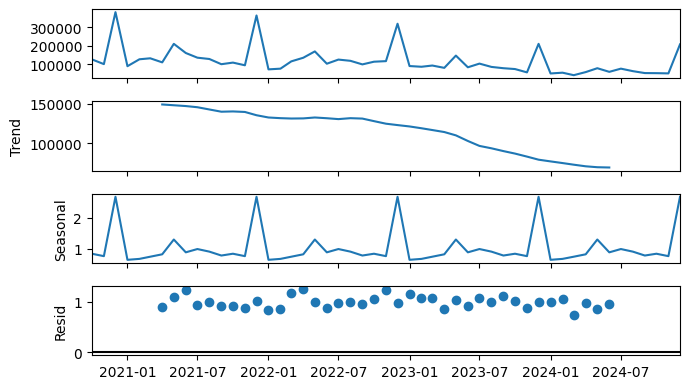

In [44]:
from pylab import rcParams
rcParams['figure.figsize']= 7,4

decomposition = seasonal_decompose(b2_ventasnetas, model='multiplicative')
decomposition.plot();

- Multiplicative model is used when we see there is a percentage increase in the seasonality rather than an additive increase.
- Exponential increase vs additive increase with regards to trend.

In [45]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

print('Trend', '\n', trend.head(12), '\n')
print('Seasonal', '\n', seasonal.head(12), '\n')
print('Residual', '\n', residual.head(12))

Trend 
 Time_Stamp
2020-10-01              NaN
2020-11-01              NaN
2020-12-01              NaN
2021-01-01              NaN
2021-02-01              NaN
2021-03-01              NaN
2021-04-01    149133.901667
2021-05-01    148138.710000
2021-06-01    147120.101667
2021-07-01    145643.789167
2021-08-01    142796.201667
2021-09-01    139972.660000
Name: trend, dtype: float64 

Seasonal 
 Time_Stamp
2020-10-01    0.838602
2020-11-01    0.760843
2020-12-01    2.667018
2021-01-01    0.643271
2021-02-01    0.673023
2021-03-01    0.743053
2021-04-01    0.820186
2021-05-01    1.294748
2021-06-01    0.883549
2021-07-01    0.989175
2021-08-01    0.905784
2021-09-01    0.780747
Name: seasonal, dtype: float64 

Residual 
 Time_Stamp
2020-10-01         NaN
2020-11-01         NaN
2020-12-01         NaN
2021-01-01         NaN
2021-02-01         NaN
2021-03-01         NaN
2021-04-01    0.895882
2021-05-01    1.096495
2021-06-01    1.234878
2021-07-01    0.937366
2021-08-01    0.988874
2021-09-0

#### Forecasting

Split the data into train and test and plot the training and test data. [30% of the most recent data should be in the test set]

In [46]:
train    =   b2_ventasnetas[0:int(len(b2_ventasnetas)*0.7)]
test     =   b2_ventasnetas[int(len(b2_ventasnetas)*0.7):]

In [47]:
print(train.shape)
print(test.shape)

(35, 1)
(16, 1)


In [48]:
print('First few rows of Training Data','\n',train.head(),'\n')
print('Last few rows of Training Data','\n',train.tail(),'\n')
print('First few rows of Test Data','\n',test.head(),'\n')
print('Last few rows of Test Data','\n',test.tail(),'\n')

First few rows of Training Data 
             Ventas netas
Time_Stamp              
2020-10-01      125853.5
2020-11-01      100015.5
2020-12-01      382721.0
2021-01-01       88804.5
2021-02-01      126349.6 

Last few rows of Training Data 
             Ventas netas
Time_Stamp              
2023-04-01      79713.35
2023-05-01     146399.75
2023-06-01      82816.75
2023-07-01     102809.50
2023-08-01      84844.50 

First few rows of Test Data 
             Ventas netas
Time_Stamp              
2023-09-01      77765.00
2023-10-01      73205.00
2023-11-01      55153.92
2023-12-01     210299.05
2024-01-01      49203.95 

Last few rows of Test Data 
             Ventas netas
Time_Stamp              
2024-08-01      61817.25
2024-09-01      51317.80
2024-10-01      50853.50
2024-11-01      49596.00
2024-12-01     207390.70 



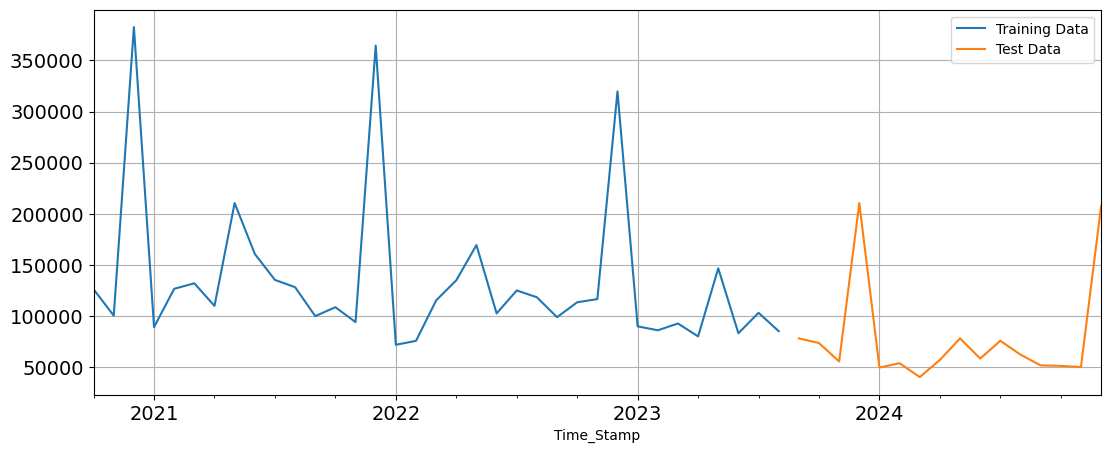

In [49]:
train['Ventas netas'].plot(figsize=(13,5), fontsize=14)
test['Ventas netas'].plot(figsize=(13,5), fontsize=14)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.show()

**Building different models and comparing the accuracy metrics**

#####**Model 1: Moving Average**

For the moving average model, we are going to calculate rolling means (or moving averages) for different intervals. The best interval can be determined by the maximum accuracy (or the minimum error) over here.

For Moving Average, we are going to average over the entire data.

In [50]:
moving_average = b2_ventasnetas.copy()
moving_average.head()

,Ventas netas
Time_Stamp,
2020-10-01,125853.5
2020-11-01,100015.5
2020-12-01,382721.0
2021-01-01,88804.5
2021-02-01,126349.6


In [51]:
moving_average['Trailing_2']= moving_average['Ventas netas'].rolling(2).mean()
moving_average['Trailing_4']= moving_average['Ventas netas'].rolling(4).mean()
moving_average['Trailing_6']= moving_average['Ventas netas'].rolling(6).mean()
moving_average['Trailing_8']= moving_average['Ventas netas'].rolling(8).mean()

moving_average.head()

,Ventas netas,Trailing_2,Trailing_4,Trailing_6,Trailing_8
Time_Stamp,,,,,
2020-10-01,125853.5,NaN,NaN,NaN,NaN
2020-11-01,100015.5,112934.50,NaN,NaN,NaN
2020-12-01,382721.0,241368.25,NaN,NaN,NaN
2021-01-01,88804.5,235762.75,174348.625,NaN,NaN
2021-02-01,126349.6,107577.05,174472.650,NaN,NaN


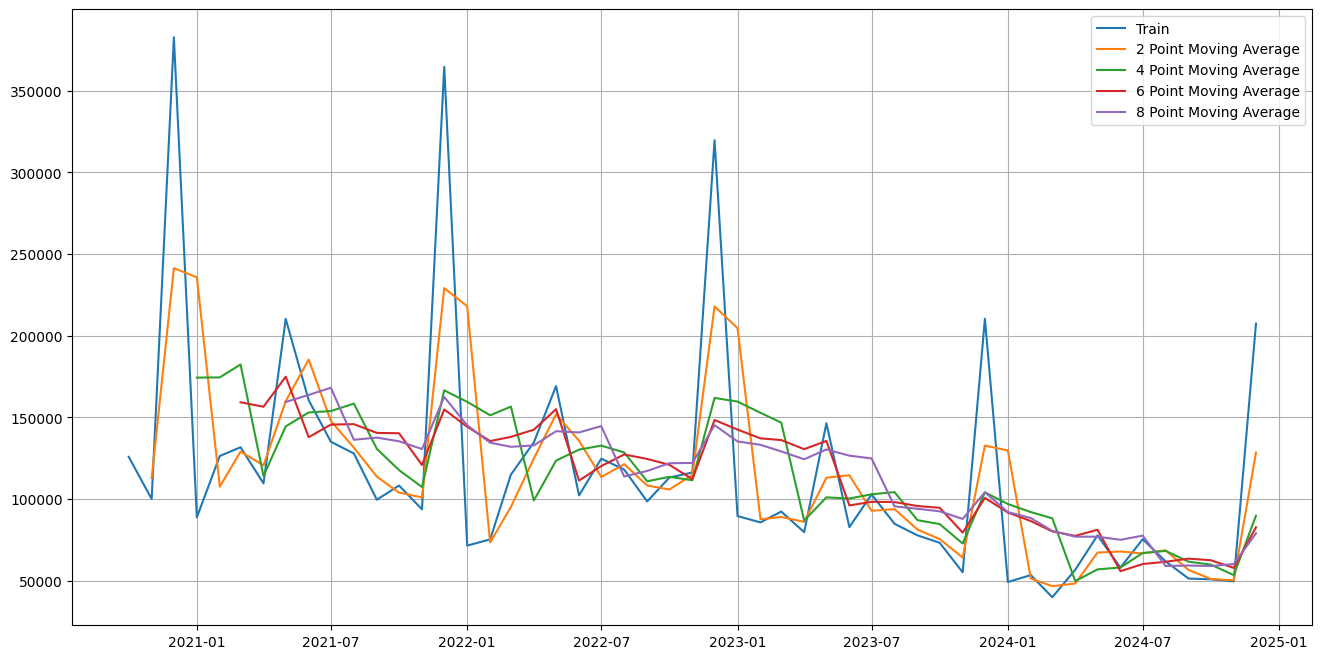

In [52]:
# ploting on the whole data

plt.figure(figsize=(16,8))
plt.plot(moving_average['Ventas netas'], label='Train')
plt.plot(moving_average['Trailing_2'], label ='2 Point Moving Average')
plt.plot(moving_average['Trailing_4'], label ='4 Point Moving Average')
plt.plot(moving_average['Trailing_6'], label ='6 Point Moving Average')
plt.plot(moving_average['Trailing_8'], label ='8 Point Moving Average')

plt.legend(loc = 'best')
plt.grid();

Let us split the data into train and test and plot this Time Series. The window of the moving average is need to be carefully selected as too big a window will result in not having any test set as the whole series might get averaged over.

In [53]:
# Creating train and test set
trailing_moving_average_train = moving_average[0:int(len(moving_average)*0.7)]
trailing_moving_average_test = moving_average[int(len(moving_average)*0.7):]

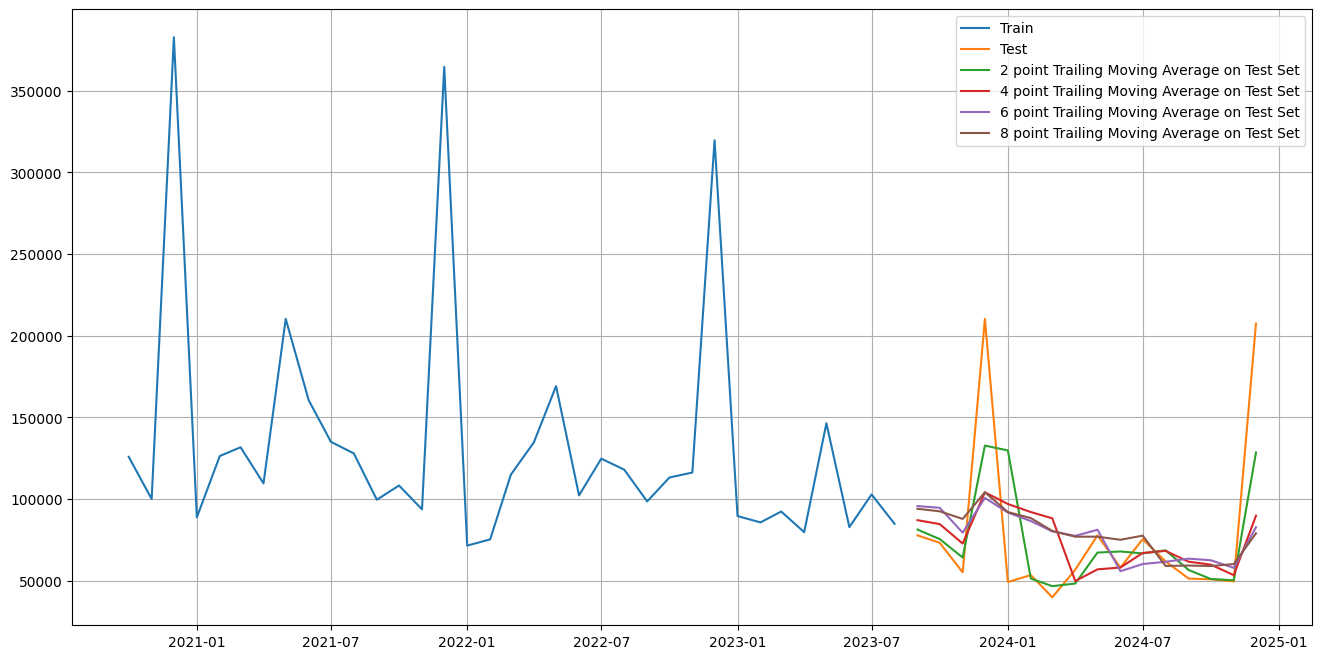

In [54]:
# Ploting on both the training and test data

plt.figure(figsize=(16,8))

plt.plot(trailing_moving_average_train['Ventas netas'], label='Train')
plt.plot(trailing_moving_average_test['Ventas netas'], label = 'Test')

plt.plot(trailing_moving_average_test['Trailing_2'], label = '2 point Trailing Moving Average on Test Set')
plt.plot(trailing_moving_average_test['Trailing_4'], label = '4 point Trailing Moving Average on Test Set')
plt.plot(trailing_moving_average_test['Trailing_6'], label = '6 point Trailing Moving Average on Test Set')
plt.plot(trailing_moving_average_test['Trailing_8'], label = '8 point Trailing Moving Average on Test Set')

plt.legend(loc = 'best')
plt.grid();

###### Model Evaluation

Done only on the test data

In [55]:
from sklearn import metrics

In [56]:
# Test data - RMSE --> 2 point trailing moving average (MA)

rmse_model1_test2 = metrics.mean_squared_error(test['Ventas netas'], trailing_moving_average_test['Trailing_2'])
print('For 2 point moving average model forecast on the training data, RMSE is %3.3f' %(rmse_model1_test2))

# Test data - RMSE --> 4 point trailing moving average (MA)

rmse_model1_test4 = metrics.mean_squared_error(test['Ventas netas'], trailing_moving_average_test['Trailing_4'])
print('For 4 point moving average model forecast on the training data, RMSE is %3.3f' %(rmse_model1_test4))

# Test data - RMSE --> 6 point trailing moving average (MA)

rmse_model1_test6 = metrics.mean_squared_error(test['Ventas netas'], trailing_moving_average_test['Trailing_6'])
print('For 6 point moving average model forecast on the training data, RMSE is %3.3f' %(rmse_model1_test6))

# Test data - RMSE --> 8 point trailing moving average (MA)

rmse_model1_test8 = metrics.mean_squared_error(test['Ventas netas'], trailing_moving_average_test['Trailing_8'])
print('For 8 point moving average model forecast on the training data, RMSE is %3.3f' %(rmse_model1_test8))

For 2 point moving average model forecast on the training data, RMSE is 1206837073.450
For 4 point moving average model forecast on the training data, RMSE is 2033505322.839
For 6 point moving average model forecast on the training data, RMSE is 2155569501.302
For 8 point moving average model forecast on the training data, RMSE is 2194017915.963


In [57]:
results_model1 = pd.DataFrame({'Test RMSE': [rmse_model1_test2, rmse_model1_test4, rmse_model1_test6, rmse_model1_test8]},
                              index = ['2 point Trailing Moving Average', '4 point Trailing Moving Average', '6 point Trailing Moving Average', '8 point Trailing Moving Average'])
results_model1

,Test RMSE
2 point Trailing Moving Average,1.206837e+09
4 point Trailing Moving Average,2.033505e+09
6 point Trailing Moving Average,2.155570e+09
8 point Trailing Moving Average,2.194018e+09


##### **Model 2 - Holts-Winters Exponential smoothing methods with additive errors**

Three parameters $\alpha$, $\beta$ and $\gamma$ are estimated in this model. Level, Trend and Seasonality are accounted for in this model.

In [58]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [59]:
print(train.shape)
print(test.shape)

(35, 1)
(16, 1)


In [60]:
# Initializing the triple exponential smoothing model
model_TES = ExponentialSmoothing(train['Ventas netas'], trend='add', seasonal='add', seasonal_periods=12)

# Fitting the model
model_TES = model_TES.fit()

- The above fit of the model is by the best parameters that python thinks for the model. It uses a brute force method to choose the parameters.



In [61]:
print('')
print('==Holt Winters model Exponential Smoothing Estimated Parameters ==')
print('')
model_TES.params


==Holt Winters model Exponential Smoothing Estimated Parameters ==



{'smoothing_level': 0.07571428571428572,
 'smoothing_trend': 0.010816326530612248,
 'smoothing_seasonal': 0.44502645502645505,
 'damping_trend': nan,
 'initial_level': 151856.30097222215,
 'initial_trend': -1774.9203661616102,
 'initial_seasons': array([-30966.1646875 , -44891.40010417, 230150.3228125 , -60085.7021875 ,
        -55430.2646875 , -15313.41885417, -38485.41135417,  63237.9103125 ,
         14465.51864583,  -9533.56885417, -13826.28135417, -39321.5396875 ]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [62]:
# Forecasting using this model for the duration of the test set
TES_predict = model_TES.forecast(len(test))
TES_predict.head()

,0
2023-09-01,69602.012897
2023-10-01,80538.201344
2023-11-01,71214.775722
2023-12-01,312595.442061
2024-01-01,48624.033496


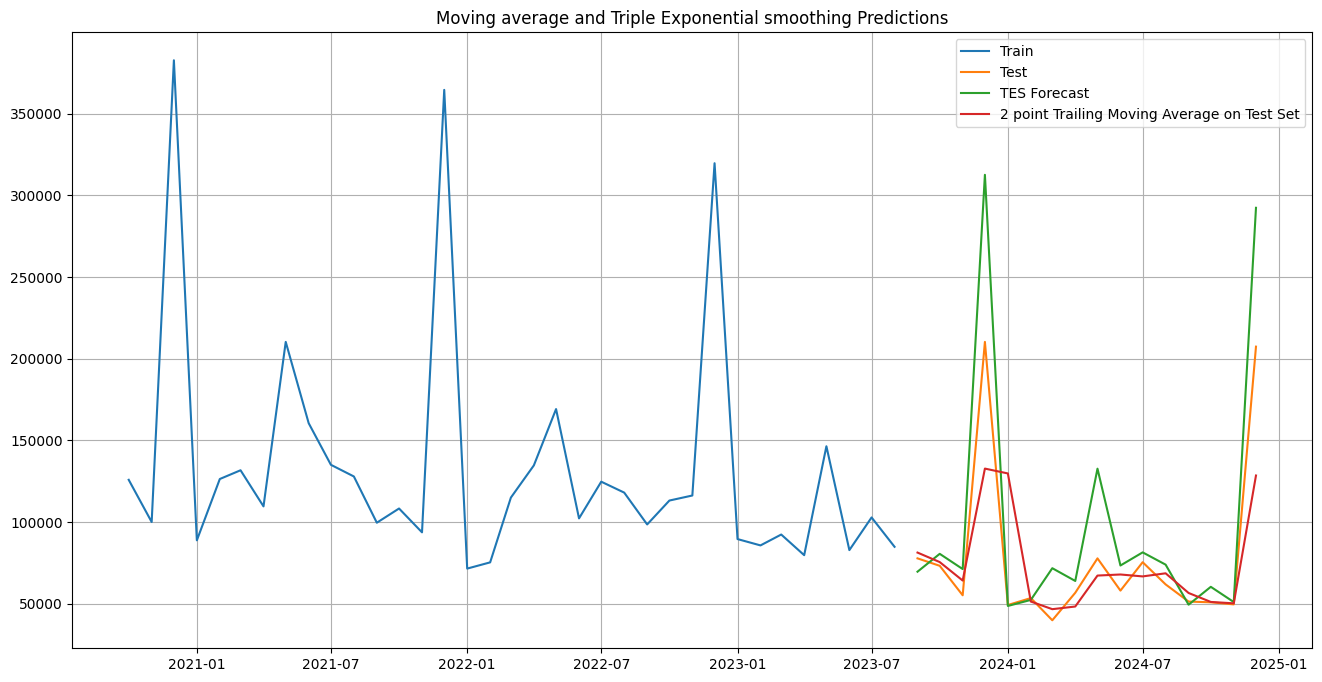

In [63]:
# plotting the training data, test data and the forecasted values
plt.figure(figsize=(16,8))

plt.plot(train['Ventas netas'], label='Train')
plt.plot(test['Ventas netas'], label = 'Test')

plt.plot(TES_predict, label = 'TES Forecast')
plt.plot(trailing_moving_average_test['Trailing_2'], label = '2 point Trailing Moving Average on Test Set')

plt.legend(loc = 'best')
plt.grid()
plt.title('Moving average and Triple Exponential smoothing Predictions');

In [64]:
RMSE_TEM=metrics.mean_squared_error(test.values, TES_predict.values)
print('TEM RMSE:', RMSE_TEM)

TEM RMSE: 1416849077.485515


In [65]:
results_model2=pd.DataFrame({'Test RMSE':[RMSE_TEM]},index=['TES add'])
results_model2

,Test RMSE
TES add,1.416849e+09


In [66]:
results_models=pd.concat([results_model1, results_model2])
results_models

,Test RMSE
2 point Trailing Moving Average,1.206837e+09
4 point Trailing Moving Average,2.033505e+09
6 point Trailing Moving Average,2.155570e+09
8 point Trailing Moving Average,2.194018e+09
TES add,1.416849e+09


- Moving average of 2 point trailing is performing the best on the test compared to the other models tested.
- Triple Exponential smoothing is over forecast. Let us try to tweak some of the parameters in order to get a better forecast on the test set.

#####**Model 3 - TES with multiplicative erros.**

In [67]:
# Initializing the double exponential smoothing model
model_TES_mult = ExponentialSmoothing(train['Ventas netas'], trend='add', seasonal='mul', seasonal_periods=12)

# Fitting the model
model_TES_mult = model_TES_mult.fit()

- The above fit of the model is by the best parameters that python thinks for the model. It uses a brute force method to choose the parameters.

In [68]:
print('')
print('==Holt Winters model Exponential Smoothing Estimated Parameters ==')
print('')
model_TES_mult.params


==Holt Winters model Exponential Smoothing Estimated Parameters ==



{'smoothing_level': 0.040357142857142855,
 'smoothing_trend': 0.008071428571428571,
 'smoothing_seasonal': 0.3084566326530612,
 'damping_trend': nan,
 'initial_level': 151856.30097222215,
 'initial_trend': -1774.9203661616102,
 'initial_seasons': array([0.77828567, 0.67662258, 2.71341376, 0.54358768, 0.57623623,
        0.88274619, 0.74104109, 1.43176238, 1.10035834, 0.93510817,
        0.9033269 , 0.71751102]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [69]:
# Forecasting using this model for the duration of the test set
TES_predict_mult = model_TES_mult.forecast(len(test))
TES_predict_mult.head()

,0
2023-09-01,76300.122435
2023-10-01,84367.444090
2023-11-01,76181.392258
2023-12-01,260079.858616
2024-01-01,59015.038741


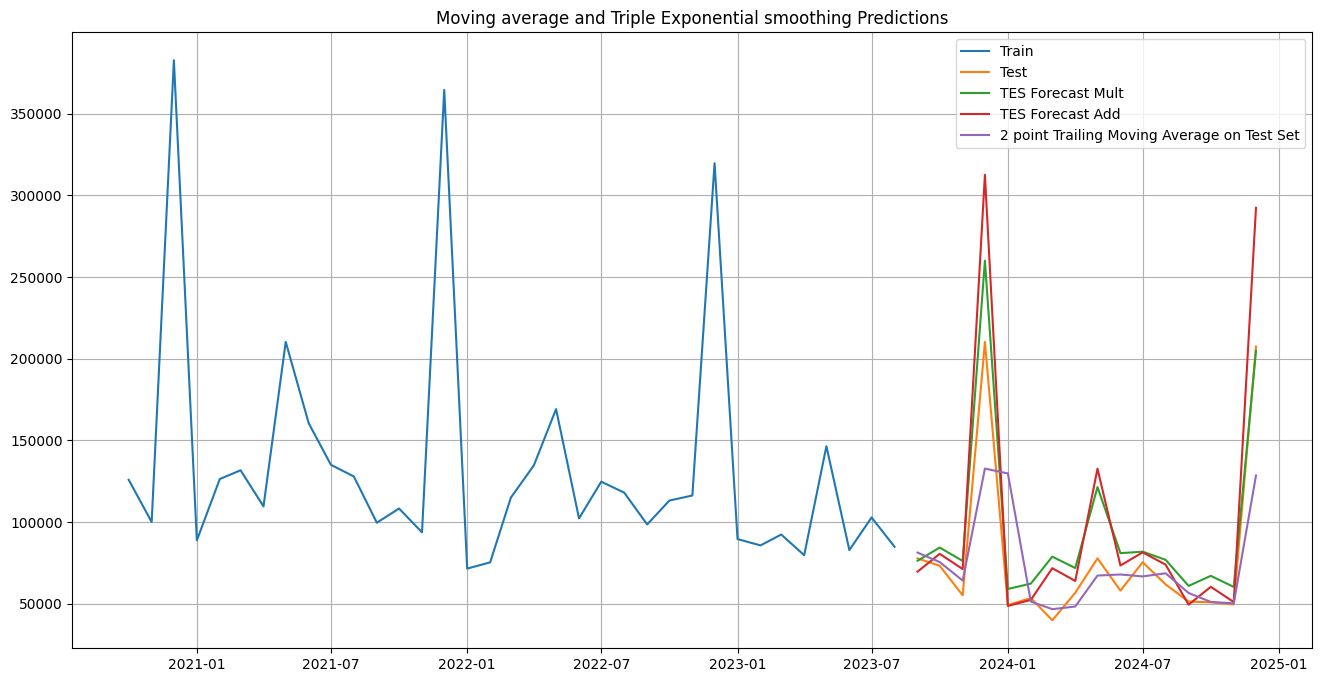

In [70]:
plt.figure(figsize=(16,8))

plt.plot(train['Ventas netas'], label='Train')
plt.plot(test['Ventas netas'], label = 'Test')

plt.plot(TES_predict_mult, label = 'TES Forecast Mult')
plt.plot(TES_predict, label = 'TES Forecast Add')
plt.plot(trailing_moving_average_test['Trailing_2'], label = '2 point Trailing Moving Average on Test Set')

plt.legend(loc = 'best')
plt.grid()
plt.title('Moving average and Triple Exponential smoothing Predictions');

In [71]:
RMSE_TES_Mult = metrics.mean_absolute_error(test.values, TES_predict_mult.values)
print('TES RMSE:', RMSE_TES_Mult)

TES RMSE: 17707.332277037753


In [72]:
results_model3=pd.DataFrame({'Test RMSE':[RMSE_TES_Mult]},index=['TES Mult'])
results_model3

,Test RMSE
TES Mult,17707.332277


In [73]:
results_models=pd.concat([results_model1, results_model2, results_model3])
results_models

,Test RMSE
2 point Trailing Moving Average,1.206837e+09
4 point Trailing Moving Average,2.033505e+09
6 point Trailing Moving Average,2.155570e+09
8 point Trailing Moving Average,2.194018e+09
TES add,1.416849e+09
TES Mult,1.770733e+04


- We see that the multiplicative seasonality triple exponential model performs better compared to the additive seasonality triple exponential smoothing model and the moving average models.
- Now we will explore fitting the model with different parameters to see if we get better results.

#####**Model 6 - TES with variations on parameters**

/ trial model

In [113]:
## First we will define an empty dataframe to store our values from the loop

tresults_TES_dif_param = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Gamma Values':[],'Train RMSE':[],'Test RMSE': []})
tresults_TES_dif_param

,Alpha Values,Beta Values,Gamma Values,Train RMSE,Test RMSE


In [114]:
ttrain=train.copy()
ttest=test.copy()

In [115]:
for i in np.arange(0.3,1.1,0.1):
    for j in np.arange(0.3,1.1,0.1):
        for k in np.arange(0.3,1.1,0.1):
            # Initialize a new model for each parameter combination
            tmodel_TES_alpha_i_j_k = ExponentialSmoothing(train['Ventas netas'], trend='add', seasonal='mul', seasonal_periods=12)
            # Fit the newly initialized model with the current parameters
            tmodel_TES_alpha_i_j_k = tmodel_TES_alpha_i_j_k.fit(smoothing_level=i,smoothing_trend=j,smoothing_seasonal=k,optimized=False)


            ttrain['predict',i,j,k] = tmodel_TES_alpha_i_j_k.fittedvalues
            ttest['predict',i,j,k] = tmodel_TES_alpha_i_j_k.forecast(len(test))

            rmse_modelt_train = metrics.mean_squared_error(ttrain['Ventas netas'],ttrain['predict',i,j,k])

            rmse_modelt_test = metrics.mean_squared_error(ttest['Ventas netas'],ttest['predict',i,j,k])


            # Create a new DataFrame for the current row
            tresults_loop = pd.DataFrame({'Alpha Values': [i], 'Beta Values': [j], 'Gamma Values': [k],
                                      'Train RMSE': [rmse_modelt_train], 'Test RMSE': [rmse_modelt_test]})
            # Use pd.concat to append the new row to the results DataFrame
            tresults_TES_dif_param = pd.concat([tresults_TES_dif_param, tresults_loop], ignore_index=True)


In [117]:
tresults_TES_dif_param.sort_values(by='Test RMSE', ascending=True).head()

,Alpha Values,Beta Values,Gamma Values,Train RMSE,Test RMSE
112,0.4,0.9,0.3,1.379705e+09,2.617232e+08
288,0.7,0.7,0.3,1.921286e+09,2.792544e+08
392,0.9,0.4,0.3,1.714978e+09,3.064049e+08
248,0.6,1.0,0.3,2.191076e+09,3.129217e+08
336,0.8,0.5,0.3,1.748823e+09,3.190691e+08


/ finish trial model

In [74]:
## First we will define an empty dataframe to store our values from the loop

results_TES_dif_param = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Gamma Values':[],'Train RMSE':[],'Test RMSE': []})
results_TES_dif_param

,Alpha Values,Beta Values,Gamma Values,Train RMSE,Test RMSE


In [75]:
for i in np.arange(0.3,1.1,0.1):
    for j in np.arange(0.3,1.1,0.1):
        for k in np.arange(0.3,1.1,0.1):
            # Initialize a new model for each parameter combination
            model_TES_alpha_i_j_k = ExponentialSmoothing(train['Ventas netas'], trend='add', seasonal='mul', seasonal_periods=12)
            # Fit the newly initialized model with the current parameters
            model_TES_alpha_i_j_k = model_TES_alpha_i_j_k.fit(smoothing_level=i,smoothing_trend=j,smoothing_seasonal=k,optimized=False,use_brute=True)
            # Brute Force Optimization: Setting use_brute=True instructs the fitting method to utilize a brute force approach to optimize the smoothing parameters. Instead of optimizing using more complex methods (such as gradient descent), it tests combinations of the parameters in a systematic way, essentially performing a grid search for the optimal parameter values.


            train['predict',i,j,k] = model_TES_alpha_i_j_k.fittedvalues
            test['predict',i,j,k] = model_TES_alpha_i_j_k.forecast(len(test))

            rmse_model4_train = metrics.mean_squared_error(train['Ventas netas'],train['predict',i,j,k])

            rmse_model4_test = metrics.mean_squared_error(test['Ventas netas'],test['predict',i,j,k])


            # Create a new DataFrame for the current row
            results_loop = pd.DataFrame({'Alpha Values': [i], 'Beta Values': [j], 'Gamma Values': [k],
                                      'Train RMSE': [rmse_model4_train], 'Test RMSE': [rmse_model4_test]})
            # Use pd.concat to append the new row to the results DataFrame
            results_TES_dif_param = pd.concat([results_TES_dif_param, results_loop], ignore_index=True)


In [76]:
results_TES_dif_param

,Alpha Values,Beta Values,Gamma Values,Train RMSE,Test RMSE
0,0.3,0.3,0.3,6.289991e+08,4.648510e+09
1,0.3,0.3,0.4,6.368709e+08,4.094744e+09
2,0.3,0.3,0.5,6.584635e+08,3.563490e+09
3,0.3,0.3,0.6,6.932540e+08,3.055822e+09
4,0.3,0.3,0.7,7.413767e+08,2.576946e+09
...,...,...,...,...,...
507,1.0,1.0,0.6,2.829600e+09,3.211892e+11
508,1.0,1.0,0.7,6.571803e+09,3.718531e+11
509,1.0,1.0,0.8,1.550959e+11,6.685147e+11
510,1.0,1.0,0.9,1.295282e+11,4.436794e+11


In [77]:
results_TES_dif_param.sort_values(by='Test RMSE', ascending=True).head()

,Alpha Values,Beta Values,Gamma Values,Train RMSE,Test RMSE
112,0.4,0.9,0.3,1.379705e+09,2.617232e+08
288,0.7,0.7,0.3,1.921286e+09,2.792544e+08
392,0.9,0.4,0.3,1.714978e+09,3.064049e+08
248,0.6,1.0,0.3,2.191076e+09,3.129217e+08
336,0.8,0.5,0.3,1.748823e+09,3.190691e+08


In [78]:
results_TES_dif_param.iloc[112]

,112
Alpha Values,4.000000e-01
Beta Values,9.000000e-01
Gamma Values,3.000000e-01
Train RMSE,1.379705e+09
Test RMSE,2.617232e+08


In [79]:
test.head()

,Ventas netas,"(predict, 0.3, 0.3, 0.3)","(predict, 0.3, 0.3, 0.4)","(predict, 0.3, 0.3, 0.5)","(predict, 0.3, 0.3, 0.6000000000000001)","(predict, 0.3, 0.3, 0.7000000000000002)","(predict, 0.3, 0.3, 0.8000000000000003)","(predict, 0.3, 0.3, 0.9000000000000001)","(predict, 0.3, 0.3, 1.0000000000000002)","(predict, 0.3, 0.4, 0.3)",...,"(predict, 1.0000000000000002, 0.9000000000000001, 0.9000000000000001)","(predict, 1.0000000000000002, 0.9000000000000001, 1.0000000000000002)","(predict, 1.0000000000000002, 1.0000000000000002, 0.3)","(predict, 1.0000000000000002, 1.0000000000000002, 0.4)","(predict, 1.0000000000000002, 1.0000000000000002, 0.5)","(predict, 1.0000000000000002, 1.0000000000000002, 0.6000000000000001)","(predict, 1.0000000000000002, 1.0000000000000002, 0.7000000000000002)","(predict, 1.0000000000000002, 1.0000000000000002, 0.8000000000000003)","(predict, 1.0000000000000002, 1.0000000000000002, 0.9000000000000001)","(predict, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002)"
Time_Stamp,,,,,,,,,,,,,,,,,,,,,
2023-09-01,77765.00,62645.290804,63469.376084,64306.973032,65180.436731,66112.041639,67124.419654,68241.224070,69488.095830,60320.697430,...,122346.691179,128689.761562,86571.620494,95691.301018,104529.331451,113196.390997,121783.594024,130368.658405,139020.289802,147801.425175
2023-10-01,73205.00,64591.575511,66033.329337,67419.381504,68802.565363,70235.838718,71773.692357,73473.971372,75400.209767,61756.401010,...,170524.427413,181169.192697,106953.588784,123458.770760,138951.545623,153688.746048,167909.429519,181845.746878,195731.435567,209808.960428
2023-11-01,55153.92,53349.196477,55774.930839,58308.955520,60954.334527,63711.675839,66578.968794,69551.301945,72620.447924,50464.914538,...,208841.884278,222987.250074,106304.334361,130130.113347,154044.089595,177977.587463,201612.757548,224411.066327,245627.901798,264316.967328
2023-12-01,210299.05,167159.451622,167819.693787,168861.709446,170275.617353,172029.794727,174072.620395,176332.315731,178714.943744,155783.657756,...,601716.281380,687549.179993,388025.512376,446930.961905,493906.086284,535837.726086,580606.096442,637494.304233,717806.642741,835820.702742
2024-01-01,49203.95,34662.191503,36393.550509,38227.704930,40226.515939,42456.320119,44990.594346,47912.910158,51320.209062,31739.430152,...,214760.656178,197023.045057,149215.858310,195468.517780,232402.478537,257200.094969,268854.787496,267284.777445,252529.291941,224213.607703


In [80]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16 entries, 2023-09-01 to 2024-12-01
Columns: 513 entries, Ventas netas to ('predict', 1.0000000000000002, 1.0000000000000002, 1.0000000000000002)
dtypes: float64(513)
memory usage: 64.2 KB


In [81]:
test[('predict', 0.4, 0.9000000000000001, 0.3)]

,predict
,0.4
,0.9
,0.3
Time_Stamp,
2023-09-01,66210.007062
2023-10-01,70253.554186
2023-11-01,59988.502641
2023-12-01,198383.515022
2024-01-01,45926.130449
2024-02-01,48999.749789


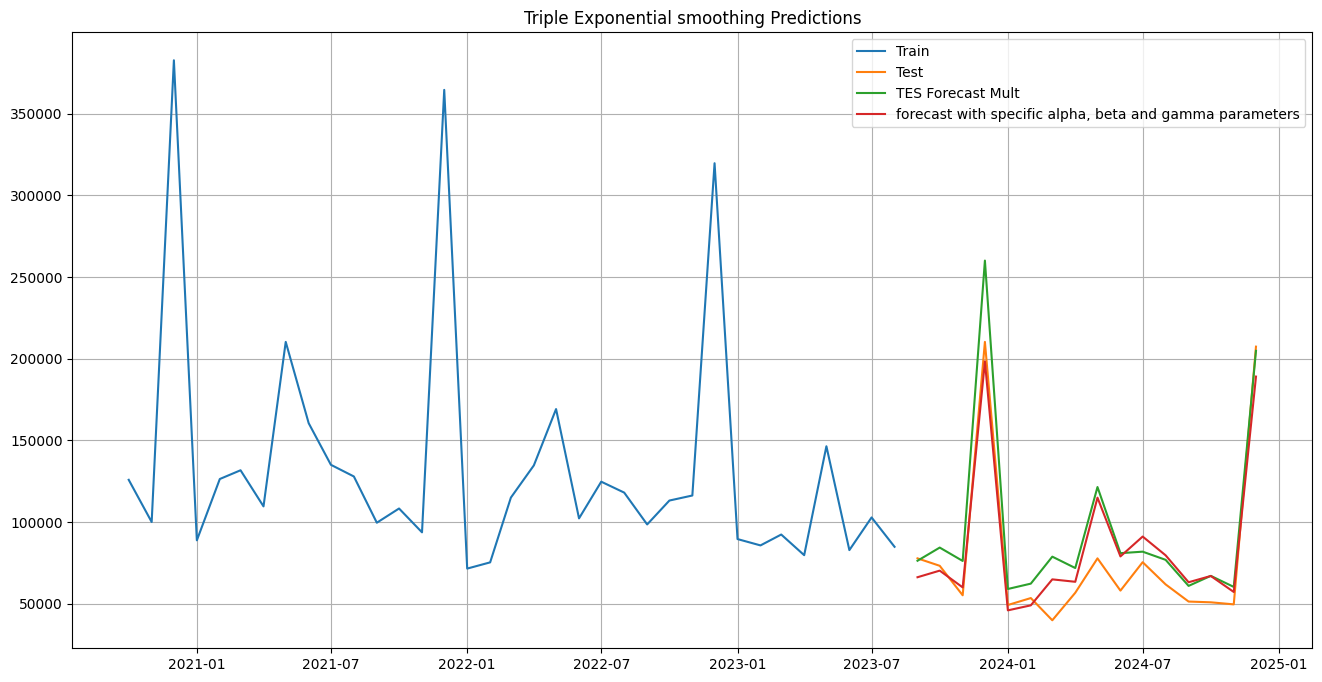

In [82]:
# plotting on both the train and test data using brute force alpha, beta and gamma determination

plt.figure(figsize=(16,8))

plt.plot(train['Ventas netas'], label='Train')
plt.plot(test['Ventas netas'], label = 'Test')

plt.plot(TES_predict_mult, label = 'TES Forecast Mult')
plt.plot(test[('predict', 0.4, 0.9000000000000001, 0.3)], label='forecast with specific alpha, beta and gamma parameters')

plt.legend(loc = 'best')
plt.grid()
plt.title('Triple Exponential smoothing Predictions');

In [83]:
test2=test[['Ventas netas']]

In [84]:
test2.head()

,Ventas netas
Time_Stamp,
2023-09-01,77765.00
2023-10-01,73205.00
2023-11-01,55153.92
2023-12-01,210299.05
2024-01-01,49203.95


In [85]:
test2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16 entries, 2023-09-01 to 2024-12-01
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ventas netas  16 non-null     float64
dtypes: float64(1)
memory usage: 256.0 bytes


In [86]:
model6=ExponentialSmoothing(train['Ventas netas'], trend='add', seasonal='mul', seasonal_periods=12)

In [87]:
# Fit the model with the specified parameters
# (optimized=False to prevent automatic parameter optimization)
model6 = model6.fit(
    smoothing_level=0.4,
    smoothing_trend=0.9,
    smoothing_seasonal=0.3,
    optimized=False,
)

\ Other model

In [110]:
modelT=ExponentialSmoothing(train['Ventas netas'], trend='add', seasonal='mul', seasonal_periods=12)

In [111]:
modelT = modelT.fit(
    smoothing_level=0.4,
    smoothing_trend=0.9,
    smoothing_seasonal=0.3,
    optimized=False,
    use_brute=True
)

# Generate the forecast for the length of the test set
forecast_modelT= modelT.forecast(len(test2))

In [112]:
rmse_modelt=metrics.mean_squared_error(test2.values, forecast_modelT.values)
print('TES RMSE:', rmse_modelt)

TES RMSE: 261723201.65858108


/ finish trial model

In [88]:
# Generate the forecast for the length of the test set
forecast_model6= model6.forecast(len(test2))

In [89]:
forecast_model6.head()

,0
2023-09-01,66210.007062
2023-10-01,70253.554186
2023-11-01,59988.502641
2023-12-01,198383.515022
2024-01-01,45926.130449


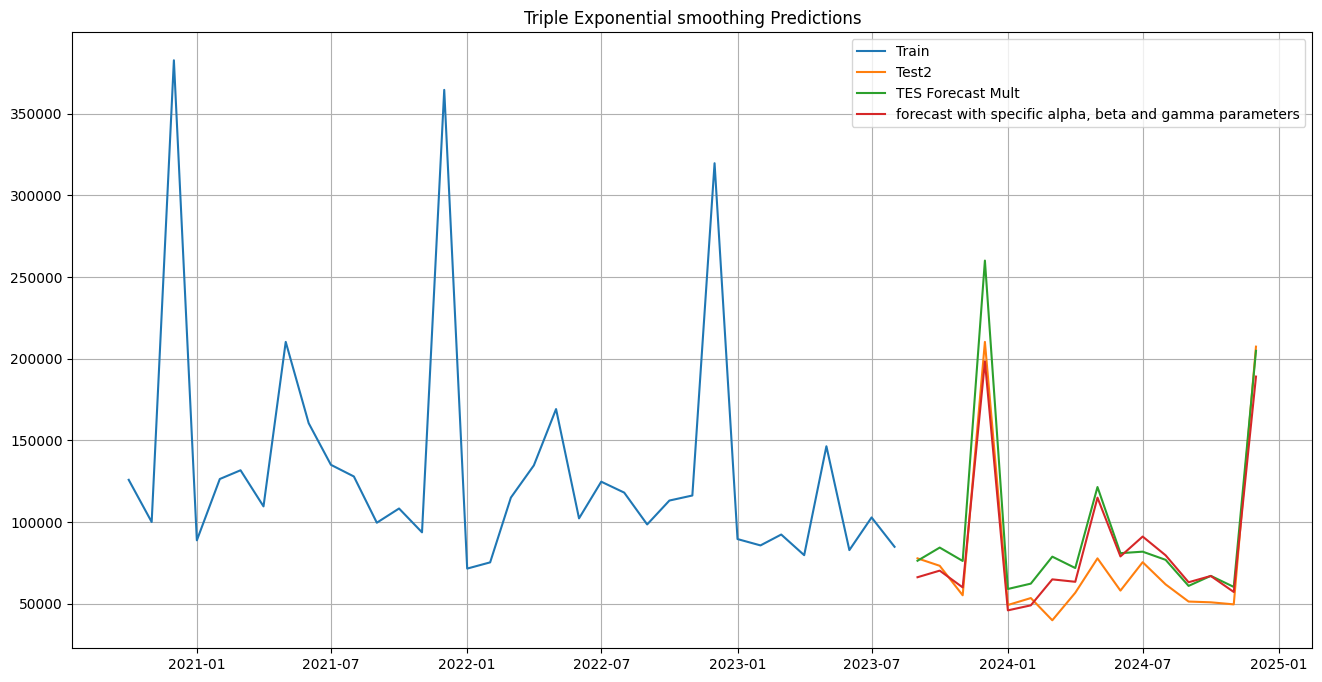

In [90]:
# plotting on both the train and test data using brute force alpha, beta and gamma determination

plt.figure(figsize=(16,8))

plt.plot(train['Ventas netas'], label='Train')
plt.plot(test2['Ventas netas'], label = 'Test2')

plt.plot(TES_predict_mult, label = 'TES Forecast Mult')
plt.plot(forecast_model6, label='forecast with specific alpha, beta and gamma parameters')

plt.legend(loc = 'best')
plt.grid()
plt.title('Triple Exponential smoothing Predictions');

In [91]:
RMSE_model6 = metrics.mean_absolute_error(test2.values, forecast_model6.values)
print('TES RMSE:', RMSE_model6)

TES RMSE: 13514.82646150253


In [92]:
results_model6=pd.DataFrame({'Test RMSE':[RMSE_model6]},index=['TES mult with alpha=0.4, beta=0.9, and gamma 0.3'])
results_model6

,Test RMSE
"TES mult with alpha=0.4, beta=0.9, and gamma 0.3",13514.826462


In [93]:
results_models=pd.concat([results_model1, results_model2, results_model3, results_model6])
results_models

,Test RMSE
2 point Trailing Moving Average,1.206837e+09
4 point Trailing Moving Average,2.033505e+09
6 point Trailing Moving Average,2.155570e+09
8 point Trailing Moving Average,2.194018e+09
TES add,1.416849e+09
TES Mult,1.770733e+04
"TES mult with alpha=0.4, beta=0.9, and gamma 0.3",1.351483e+04


In [94]:
print('Sorted by RMSE values on the Test Data:','\n',)
results_models.sort_values(by=['Test RMSE'])

Sorted by RMSE values on the Test Data: 



,Test RMSE
"TES mult with alpha=0.4, beta=0.9, and gamma 0.3",1.351483e+04
TES Mult,1.770733e+04
2 point Trailing Moving Average,1.206837e+09
TES add,1.416849e+09
4 point Trailing Moving Average,2.033505e+09
6 point Trailing Moving Average,2.155570e+09
8 point Trailing Moving Average,2.194018e+09


- model6 which was the TRIPLE EXPONENTIAL SMOOTHING Model with specific parameters was the best performing comparing with the others.

#### **Full model predictions**

In this particular we have built several models and went through a model building exercise. This particular exercise has given us an idea as to which particular model gives us the least error on our test set for this data. But in Time Series Forecasting, we need to be very vigil about the fact that after we have done this exercise we need to build the model on the whole data. Remember, the training data that we have used to build the model stops much before the data ends. In order to forecast using any of the models built, we need to build the models again (this time on the complete data) with the same parameters.

We will build the top 2 models which gave us the best accuracy (least RMSE).

##### Model 7 - TES with Calculated parameters

In [95]:
model7=ExponentialSmoothing(b2_ventasnetas,
                            trend='add',
                            seasonal='mul').fit(smoothing_level=0.4,
                                                smoothing_trend=0.9,
                                                smoothing_seasonal=0.3)

In [96]:
RMSE_fullmodel7 = metrics.mean_squared_error(b2_ventasnetas['Ventas netas'],model7.fittedvalues)

print('RMSE:',RMSE_fullmodel7)

RMSE: 730527457.3071117


In [97]:
# Getting the predictions for the same number of times stamps that are present in the test data
prediction_1 =model7.forecast(steps=len(test))

<Figure size 1600x800 with 0 Axes>

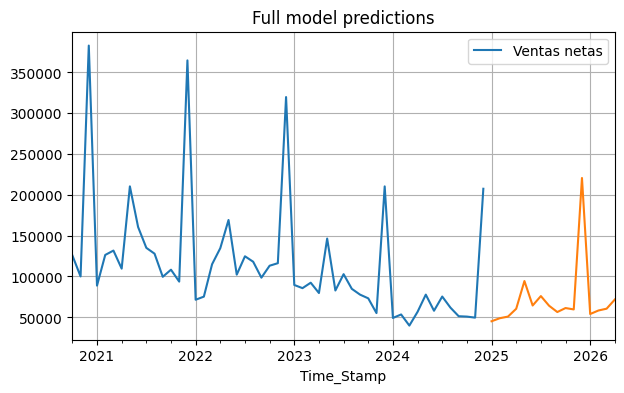

In [98]:
plt.figure(figsize=(16,8))
b2_ventasnetas.plot()
prediction_1.plot()
plt.grid()
plt.title('Full model predictions')
plt.show();

In [99]:
#In the below code, we have calculated the upper and lower confidence bands at 95% confidence level
#Here we are taking the multiplier to be 1.96 as we want to plot with respect to a 95% confidence intervals.
pred_1_df = pd.DataFrame({'lower_CI':prediction_1 - 1.96*np.std(model7.resid,ddof=1),
                          'prediction':prediction_1,
                          'upper_ci': prediction_1 + 1.96*np.std(model7.resid,ddof=1)})
pred_1_df

,lower_CI,prediction,upper_ci
2025-01-01,-8359.626251,45142.575303,98644.776857
2025-02-01,-4638.467720,48863.733834,102365.935388
2025-03-01,-2627.136730,50875.064824,104377.266378
2025-04-01,6957.873293,60460.074847,113962.276401
2025-05-01,40880.317330,94382.518885,147884.720439
2025-06-01,10943.745165,64445.946719,117948.148273
2025-07-01,22476.398516,75978.600070,129480.801624
2025-08-01,10654.652408,64156.853962,117659.055516
2025-09-01,2938.106807,56440.308361,109942.509915
2025-10-01,7824.170003,61326.371557,114828.573111


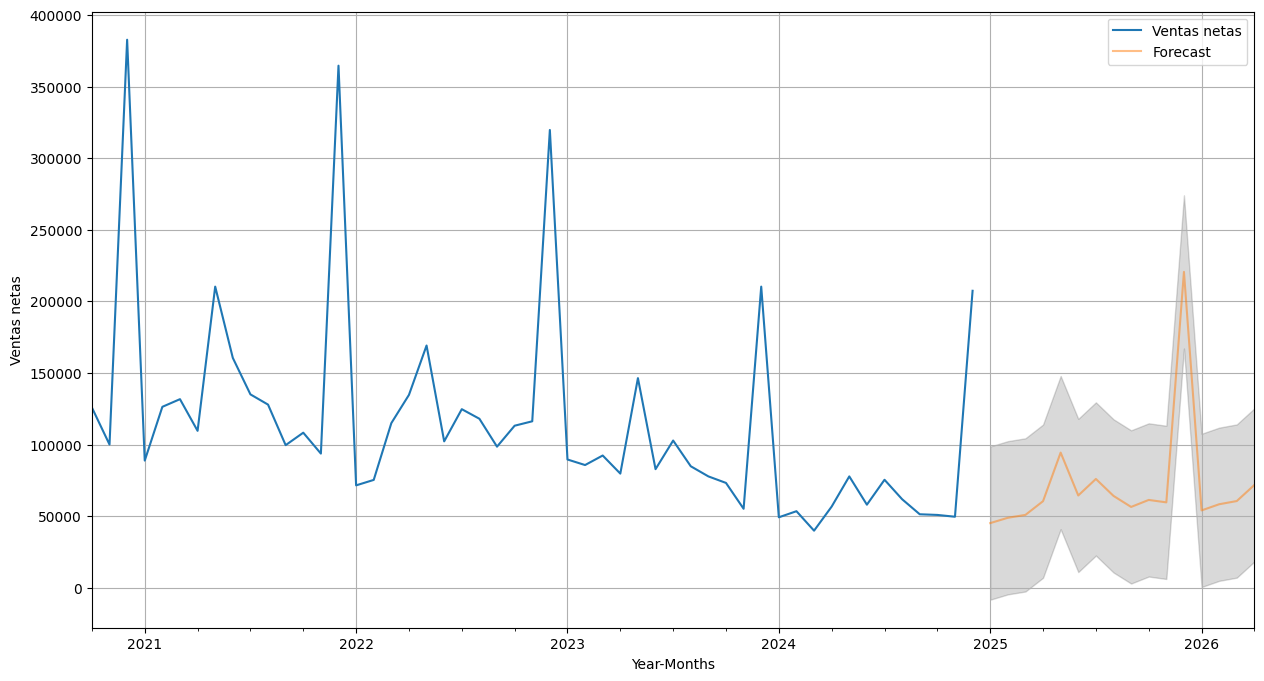

In [100]:
# plot the forecast along with the confidence band

axis = b2_ventasnetas.plot(label='Actual', figsize=(15,8))
pred_1_df['prediction'].plot(ax=axis, label='Forecast', alpha=0.5)
axis.fill_between(pred_1_df.index, pred_1_df['lower_CI'], pred_1_df['upper_ci'], color='k', alpha=.15)
axis.set_xlabel('Year-Months')
axis.set_ylabel('Ventas netas')
plt.legend(loc='best')
plt.grid()
plt.show()

##### Model 3 - TES Automatic

In [101]:
full_model3=ExponentialSmoothing(b2_ventasnetas,
                            trend='add',
                            seasonal='mul').fit(smoothing_level=0.040357142857142855,
                                                smoothing_trend=0.008071428571428571,
                                                smoothing_seasonal=0.3084566326530612)

In [102]:
RMSE_full_model3 = metrics.mean_squared_error(b2_ventasnetas['Ventas netas'],full_model3.fittedvalues)

print('RMSE:',RMSE_full_model3)

RMSE: 314798514.4371992


In [103]:
# Getting the predictions for the same number of times stamps that are present in the test data
prediction_2 =full_model3.forecast(steps=len(test))

<Figure size 1600x800 with 0 Axes>

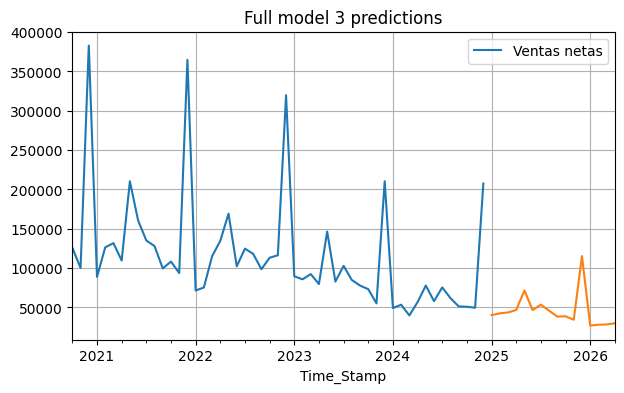

In [104]:
plt.figure(figsize=(16,8))
b2_ventasnetas.plot()
prediction_2.plot()
plt.grid()
plt.title('Full model 3 predictions')
plt.show();

In [105]:
#In the below code, we have calculated the upper and lower confidence bands at 95% confidence level
#Here we are taking the multiplier to be 1.96 as we want to plot with respect to a 95% confidence intervals.
pred_2_df = pd.DataFrame({'lower_CI':prediction_2 - 1.96*np.std(full_model3.resid,ddof=1),
                          'prediction':prediction_2,
                          'upper_ci': prediction_2 + 1.96*np.std(full_model3.resid,ddof=1)})
pred_2_df

,lower_CI,prediction,upper_ci
2025-01-01,5148.201534,40235.791270,75323.381007
2025-02-01,7343.666668,42431.256404,77518.846141
2025-03-01,8511.647765,43599.237501,78686.827238
2025-04-01,11634.777903,46722.367640,81809.957376
2025-05-01,36396.007007,71483.596744,106571.186481
2025-06-01,11585.643381,46673.233118,81760.822855
2025-07-01,18463.377756,53550.967492,88638.557229
2025-08-01,10814.817928,45902.407664,80989.997401
2025-09-01,3185.987129,38273.576866,73361.166603
2025-10-01,3693.543926,38781.133663,73868.723400


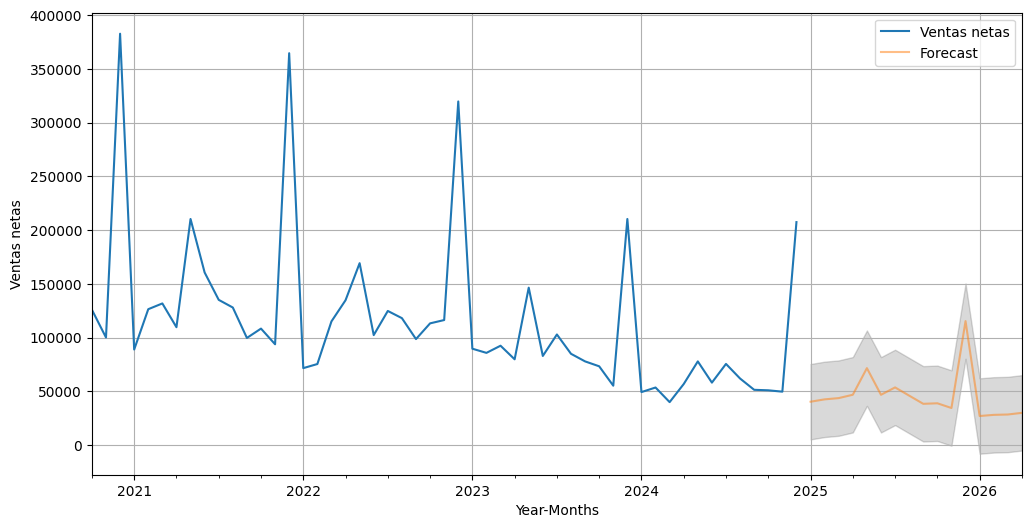

In [107]:
# plot the forecast along with the confidence band

axis = b2_ventasnetas.plot(label='Actual', figsize=(12,6))
pred_2_df['prediction'].plot(ax=axis, label='Forecast', alpha=0.5)
axis.fill_between(pred_2_df.index, pred_2_df['lower_CI'], pred_2_df['upper_ci'], color='k', alpha=.15)
axis.set_xlabel('Year-Months')
axis.set_ylabel('Ventas netas')
plt.legend(loc='best')
plt.grid()
plt.show()

#### ARIMA & SARIMA MODELS

### Reliz Store

## GENERAL INFORMATION - TIME SERIES


*   A time series is a sequence of measurments on the same variable collected over time.


*   The measurments are made at regular time periods.


*   A time series is stationary when its statistical properties, such as mean and variance, do not change over time and periodic variations have been removed.
* Multiple time series exist. (multivariate time series)

Intervals of time series
* Yearly     - GDP, Macro-economic series
- Quarterly  - Revenue
- Monthly    - Sales, Expenditure
- Weekly     - Demand
- Daily      - Closing price of stock
- Hourly     - AAQI

Assumptions
- Data are **not independent**
- List of observations where the ordering matters.
- **Ordering is very important becasue there is dependency and changing the order will change the data structure.**

Forecasting

 Not all series is equally easy or difficutl to forecast. It depends on
- How well the contributing factors are understood
- Hoy much data is available.

The forecast should not be larger than the lenght of the data available.

Components of Time Series
- Trends (systematic component)
    - The trend is the data's long-term movement or direction, showing whether it is rising, falling, or staying mostly unchanged overtime.
- Seasonality (systematic component)
   - Seasonality refers to patterns that frequently depend on cyclical patterns, seasons, months, and days of the week.
   - Seasonality is a relative increase or decrease of sales (demand or consumption) every period (quarter or month) compared to the yearly average.
   -   Represents intra-year stable fluctuations repeatable year after year with respect to timing, direction and magnitude.
   - Normal variations that recur every year to the same extent
   - A Yearly series does not have seasonality
- Random Components
    - Unpredictable fluctuations or noise in the data that result from random or chance events and cannot be linked to any particular pattern or trend are known as random variation (also known as irregularity).
    - Error or noise
    - The part of the series that cannot be explained through Systematic component forms the irregular component.
    - This component is assumed to have a normal distributon with 0 mean nad constant varianse of sigma2. ???

**Decomposition Model**

Decomposing time series data allows for better understanding and analysis by separating it into its constituent components, such as trend, seasonality, and irregular variations.

Additive model - when seasonal variations are consistent over time (if they do not change with trend)
  - sales = trend + seasonality + error

Multimicative model
  - sales = trend * seasonality * error

Multiplicative model is used when we see there is a percentage increase in the seasonality rather than an additive increase.

Exponential increase vs additive increase with regards to trend.


DOWNSAMPLING
example: change montly series to quaterly
(interpolation)????

UPSAMPLING
example: change montly series to daily


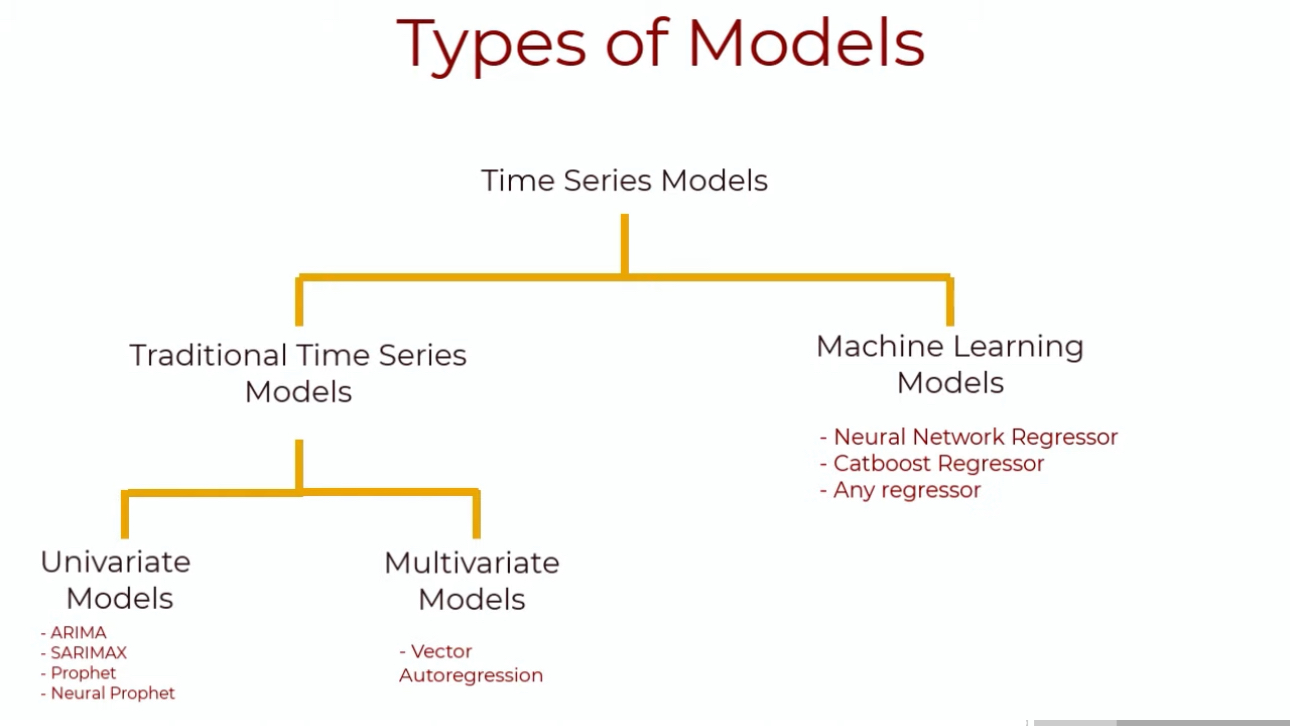

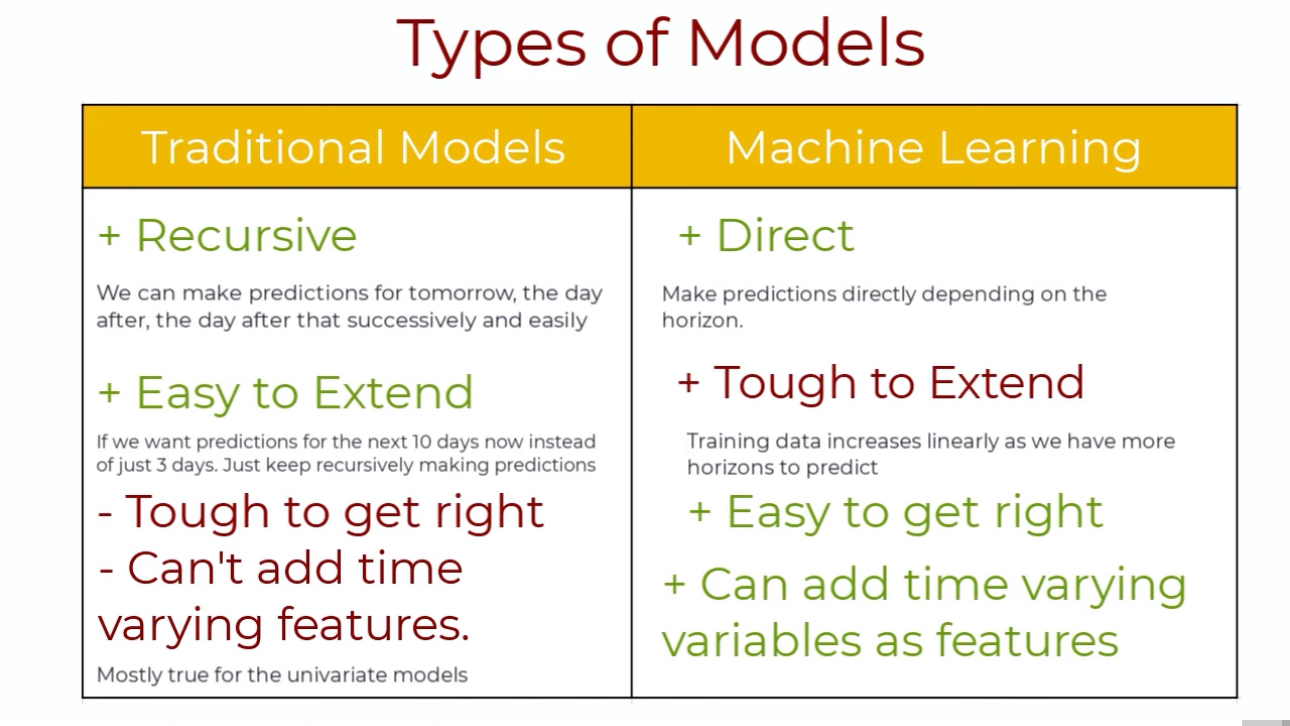

##GENERAL INFORMATION - FORECASTING

- Forecast is done under the assumption that the future will be similar the same as the past. Following a trend. The change is gradual and predictable.
- Events like Demonetization would throw the forecast into disarray.
- We will see continuous univariate forecast rather than categorical forecast.
- Data must be relevant. Only the relevant part of the series should be used for forcasting.

The term 'forecast range' describes the time horizon over which predictions are made.


- Depending what you try to understand you set the forecast range. For example to undrestand where the industry is going you use **long-term data vs short-term data**.

**long-Term  forecast** 5-10 years - Strategic decision making

**Mid-term forecast** 2-5 years - Manpower hiering / Route alteration

**Short-term forecast** - 2-6 months - pilot / Cabin Crew rostering or Dynamic pricing

/

**TYPES OF FORECAST**

- **SIMPLE FORECAST** (Naive forecast)
    - Ideal for steady time series data and assumes future values equal to most recent observation.
- **MOVING AVERAGE FORECAST** Usefull when you not take into acount trend and seasonality.
    - Smooths out fluctuations, providing a fundamental benchmark for forecasting based on historical averages. Offers smoother estimates by averaging recent observations compared to naive or average prediction methods.

- **LONG-TERM MOVEMENT** ignoring short term fluctuations.
    - defined through trend analysis or regression, indicating the overall directionality of the data over an extended period.

EXPONENTIAL SMOOTHING METHOD

- weighted averages of past observations

- **weights decaying** as observations get older

- practically speaking, only the recent observations matter

- one or more parameters control how fast the weights decay

- these parameters have values between 0 and 1.

- your current forecast is an average of what your current value is and your current forecast. A combination of where you are and where you think you are. In other words, your forecast for tomorrow is the forecast for today corrected by how wrong you were in your forecast. (FORMULAS) alpha parameter for info on actual time series. alpha is the single exponential smoothing parameter - corresponds to level.

DOUBLE EXPONENTIAL SMOOTHING
- Applicable when data has Trend but no seasonality
- An extension of SES (Simple exponential smoothing)
- Two separate components are considered : Level and Trend
- Level is the local mean
- Trend is whether is going down or not. Beta parameter corresponds to trend info. Second smoothing parameter
- Also known as **Holt model** - used for double exponential smoothing.

**HOLT-WINTER'S MODEL** TRIPLE EXPONENTIAL SMOOTHING
- Includes seasonality with a third parameter gamma
- Because seasonality can be additive or multiplicative, HW model can be additive or multiplicative.
- Simultainously smooths the level, trend, and seasonality.

RECAP
  - Exponential smoothing involves calculating weighted averages of past observations
  - Various methods of exponential smoothing, such as simple esponential smoothing, which assigns exponentially decreasing weights to past observations and double exponential smoothieng i.e. Holt's Method, which incorporates trend estimation.
  - In exponential smoothing one or more parameters control how fast the weights decay.
/

MODEL VALIDATION

Predictive power of a model is estimated by comparing its forecasting performance on a Test Data.

The model which gives smallest measure of error between forecast and actual series is the 'best'.

The forecasts for training data are called fitted values.

Each of the models is tested agains the observed values of the series for **hold-out period**.

For time series hold-out sample has to be the most recent period because of the ordered nature of the data.

**Measures of forecast Accuracy**
- Residual sum of squares (RSS)
- Mean sum of squares (MSS)
- Mean absolute deviation (MAD)
- Mean absolute percent error (MAPE)

##GENERAL INFORMATION - ARIMA and SARIMA FORECASTING

**AR / ARMA / ARIMA / SARIMA**
- AR - Auto Regressive model
- ARMA - Auto Regressive Moving average model
- ARIMA - Auto Regressive Integrated Moving Average
- SARIMA - Seasonal Auto Regresive In Moving Average

### Concept Of Stationarity

A time series is considered to be stationary  when its Statistical properites such as the variance and (auto) correlation are constant overtime.

**<font color='blue'>Dickey-Fuller Test</font>** - Dicky Fuller Test on the timeseries is run to check for stationarity of data.

- **Null Hypothesis $H_{0}$**: Time Series is non-stationary.
- **Alternate Hypothesis $𝑯_{𝒂}$**: Time Series is stationary.

*So Ideally if p-value < 0.05 then null hypothesis: TS is non-stationary is rejected else the TS is non-stationary is failed to be rejected .*

#### HOW TO MAKE A TIME SERIES STATIONARY? - Differencing 'd'

- Differencing **'d'** is done on a non-stationary time series data one or more times to convert it into stationary.



- **(d=1) 1st order differencing is done where the difference between the current and previous (1 lag before) series is taken and then checked for stationarity using the ADF(Augmented Dicky Fueller) test. If differenced time series is stationary, we proceed with AR modeling. Else we do (d=2) 2nd order differencing, and this process repeats till we get a stationary time series**

    - <font color='blue'> 1st  order differencing equation is : $𝒚_{𝒕} = (𝒚_{𝒕} − 𝒚_{𝒕-1})$
	- 2nd order differencing equation is : $𝒚_{𝒕} = (𝒚_{𝒕} − 𝒚_{𝒕-1}) − (𝒚_{𝒕-1} -y_{t-2})$		and so on…</font>


- The variance of a time series may also not be the same over time.   To remove this kind of non-stationarity, we can transform     the data. **If the variance is increasing over time, then a log transformation can stabilize the variance.**

### AR ->

Auto Regressive model

- Autoregression means **regression of a variable on itself** which means **Autoregressive models use previous time period values to predict the current time period values.**


- One of the fundamental assumptions of an AR model is that the **time series is assumed to be a stationary process.**


- An AR(p) model (Auto-Regressive model of order p) can be written as:
## <font color='blue'> $y_{t}$ =   $φ_{1} y_{t-1} + φ_{2}y_{t-2} + ……+ φ_{p} y_{t-p} + ε_{t}$</font>

- <font color='blue'>$ε_{t}$ </font>**is an error term which is an independent and identically distributed random variable (or in other words, a white noise) with the parameters mean = 0 and standard deviation = σ**
- The <font color='blue'>φ </font>**are regression coefficients multiplied by lagged time series variable, which captures the effect of the input variable on the output, provided intermediate values do not change.**



PACF -> Partial auto correlation function

Lowest **AIC** Approach : the lowest Akaike Information Criteria (AIC) value compared among different orders of ‘p’ is considered.

Lowest AIC while choosing AR(p) means to get the most likely and the least value of 'p'


### MA ->

Moving Average model

df- Moving average model **considers past residual values to predict the current time period values.**
  These past residuals are past prediction errors.
    

- For a MA model, **the residual or error component is modeled.**


- The moving average model MA(q) of  order q can be represented as:

### <font color='blue'>$y_{t} =  ε_{t} + θ_{1}ε_{t-1} +……+ θ_{q}ε_{t-q}$</font>

- **Where $y_{t}$  time series variable, θ are numeric coefficients multiplied to lagged residuals and ε is the residual term considered as a purely random process with mean 0, variance $σ^{2}$ and  $Cov(ε_{t-1},ε_{t-q})$ = 0.**

#### Choose the order 'q' of MA model

- We look at the Autocorrelations of a stationary Time Series to understand the order of Moving Average models.


- For a MA model,  

<i>1) **ACF Approach** : ACF (Autocorrelation Function) values cut off at a certain lag. ACF vanishes, and there are no coefficients that far back; thus, the cut-off value where this happens is taken as the order of MA as ‘q’. This can be seen from the ACF plot.</i>



<i>2) <font color='blue'>**Lowest AIC Approach** : the lowest Akaike Information Criteria (AIC) value compared among different orders of ‘q’ is considered. </i></font>


## Methods and functions for TIME SERIES FORCAST

date_range()
- df['date']= pd.date_range(start='1/1/1955', periods=len(df), freq='D')

set_index()

- df.set_index('date', inplace = True)



df=pd.read_csv('name of file',parase_dates=True, index_col='column name')

print(df)

.rolling().mean()

rolling and then a specific window in time. ??

Brute Force Optimization: Setting use_brute=True instructs the fitting method to utilize a brute force approach to optimize the smoothing parameters. Instead of optimizing using more complex methods (such as gradient descent), it tests combinations of the parameters in a systematic way, essentially performing a grid search for the optimal parameter values.

# NOTES:
- COMPARE STOCK AT HAND WITH SALES TO SEE IF THERE IS A RELATIONSHIP
- COMARE CLIENT FLOW WITH SALES